# AD case-control phenotyping

Cases are participants who have been exposed to an antidepressant class, but who are controls?

- participants who have never been prescribed the target class (no prescriptions or only prescriptions of other classes) ("Controls")
- participants who have never been prescribed an antidepressant ("Super Controls")


Explore effects of classification using causal diagram simulations ([`simDAG`](https://robindenz1.github.io/simDAG/)).

In [3]:
library(simDAG)
library(dplyr)
library(stringr)
library(ggplot2)
library(igraph)
library(parallel)

Set up DAG.

- two drug classes (`A`, `B`)
- an unassayed SNP that influences probability of being prescribed both classes (`SNP*`)
- assayed SNPs that influence probability of being prescribed only one of the classes (`SNP1` or `SNP4`)
- an assayed SNP that increases probability of being prescribed both classes (`SNP2`)
- an assaedy SNP that increases probability of being prescribed class `A` but decreases probability of being prescribed class `B` (`SNP3`)

In [4]:
FRQ <- 0.4

# simulate additive genotypes from allele frequency
rgenotype <- function(n, frq) {
  genotype_probs <- c((1-FRQ)^2, 2*FRQ*(1-FRQ), FRQ^2)
  genotype_values <- 0:2 - weighted.mean(0:2, w = genotype_probs)
  out <- as.numeric(rcategorical(n, labels = genotype_values, probs = genotype_probs))
  return(out)
}

# case/control phenotypes based on prescribing classes
# `cases` and `controls` are logicial arguments evaluated on `data`
# `cases` == TRUE -> 1, controls == `TRUE` -> 0, others -> NA
node_casecontrol <- function(data, parents, cases, controls) {
  cases_idx <- eval(parse(text = cases), envir = data)
  controls_idx <- eval(parse(text = controls), envir = data)
  status <- rep.int(NA, times = nrow(data))
  status[cases_idx] <- 1
  status[controls_idx] <- 0
  return(status)
}

dag <- empty_dag() +
  node("SNP*", type = "rgenotype", frq = FRQ) +
  node("SNP1", type = "rgenotype", frq = FRQ) +
  node("SNP2", type = "rgenotype", frq = FRQ) +
  node("SNP3", type = "rgenotype", frq = FRQ) +
  node("SNP4", type = "rgenotype", frq = FRQ) +
  node("A", type = "binomial",
       parents = c("SNP3", "SNP*", "SNP1", "SNP2"),
       betas = c(0.2, 0.2, 0.2, 0.2),
       intercept = arm::logit(0.15), coerce2numeric = TRUE) +
  node("B", type = "binomial",
       parents = c("SNP3", "SNP*", "SNP2", "SNP4"),
       betas = c(0.2, 0.2, -0.2, 0.2),
       intercept = arm::logit(0.10), coerce2numeric = TRUE) +
  node("A vs !A", type = "casecontrol", parents = "A",
       cases = "A == 1", controls = "A == 0") +
  node("A vs !A!B", type = "casecontrol", parents = c("A", "B"),
       cases = "A == 1", controls = "A == 0 & B == 0") +
  node("A vs B", type = "casecontrol", parents = c("A", "B"),
       cases = "A == 1 & B == 0", controls = "A == 0 & B == 1")


Loading required namespace: ggforce



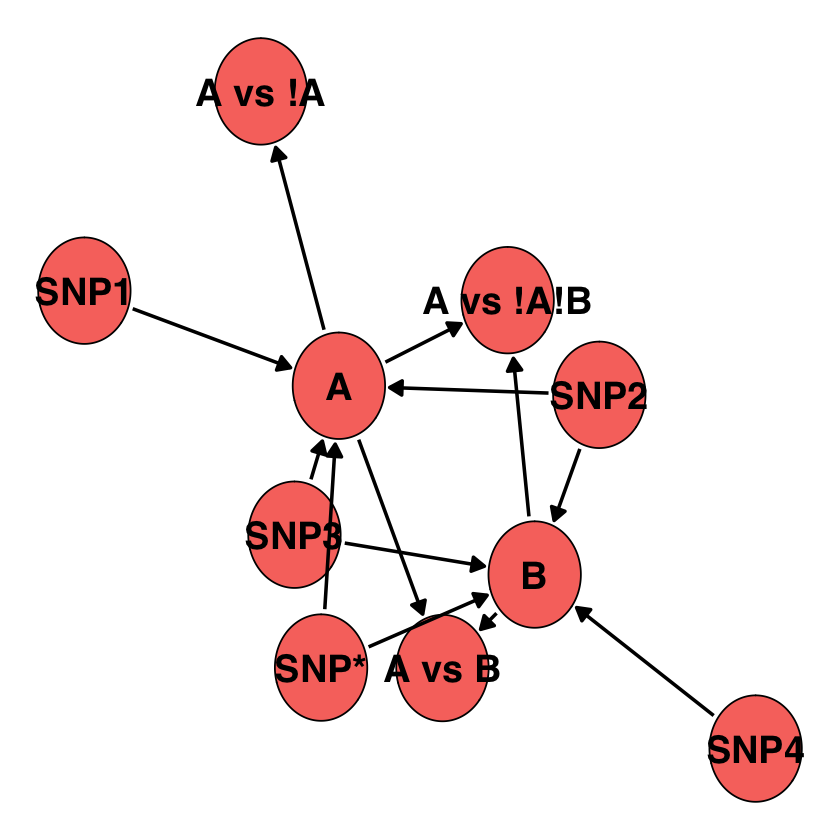

In [5]:
plot(dag, node_size = 0.3)

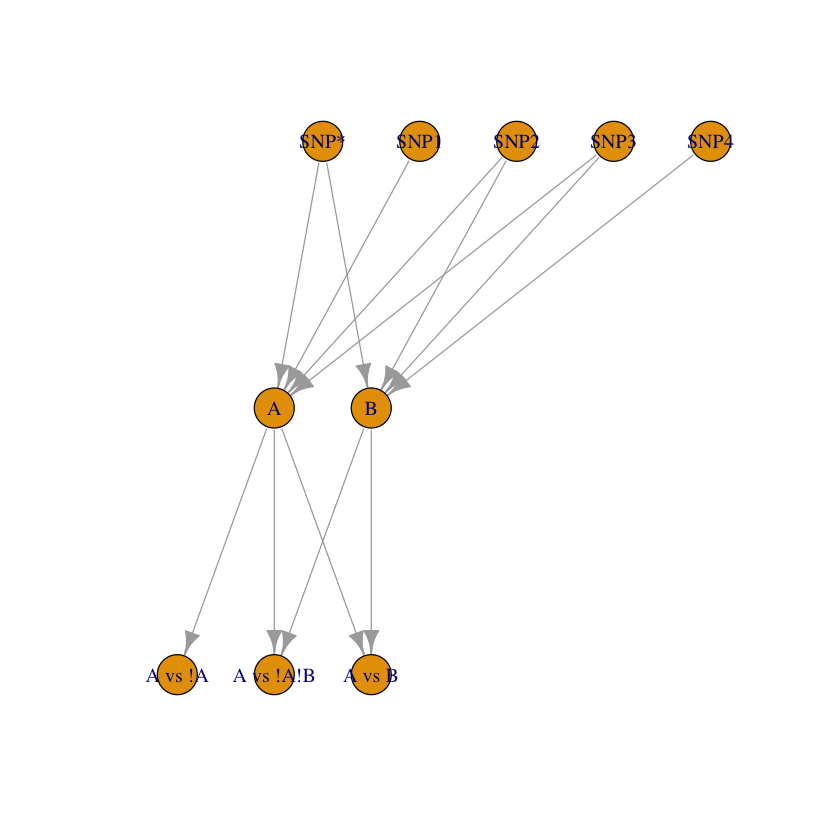

In [6]:
dag_matrix <- dag2matrix(dag)
dag_graph <- graph_from_adjacency_matrix(adjmatrix = dag_matrix, mode="directed")
dag_tree <- layout_as_tree(dag_graph)

plot(dag_graph, layout = dag_tree)

Simulate from DAG and run logistic regression for different case/control definitions on assayed SNPs.

In [7]:
sim_model <- function(replicate, dag, n_sim) {
  sim_dat <- sim_from_dag(dag, n_sim = 200000)

  model1 <- glm(`A vs !A` ~ + `SNP1` + `SNP2` + `SNP3` + `SNP4` , data=sim_dat, family = "binomial")
  model2 <- glm(`A vs !A!B` ~ + `SNP1` + `SNP2` + `SNP3` + `SNP4` , data=sim_dat, family = "binomial")
  model3 <- glm(`A vs B` ~ + `SNP1` + `SNP2` + `SNP3` + `SNP4` , data=sim_dat, family = "binomial")

  models <- list("A Case - A Control" = model1,
                 "A Case - A/B Control" = model2,
                 "A Case - B Case" = model3)

  snp_coefs <- bind_rows(lapply(models, function(m) {
    as_tibble(summary(m)$coefficients, rownames = "term")
  }), .id = "model") |>
    filter(str_detect(term, "SNP")) |>
    mutate(replicate = replicate)

  return(snp_coefs)
}

In [8]:
sim_model(1, dag, n_sim = 200000)

Loading required namespace: Rfast



model,term,Estimate,Std. Error,z value,Pr(>|z|),replicate
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A Case - A Control,SNP1,0.217171792,0.008888547,24.4327677,7.673555e-132,1
A Case - A Control,SNP2,0.197543910,0.008873493,22.2622500,8.582983e-110,1
A Case - A Control,SNP3,0.203733092,0.008853765,23.0108985,3.625857e-117,1
A Case - A Control,SNP4,0.008509705,0.008964867,0.9492283,3.425045e-01,1
A Case - A/B Control,SNP1,0.218081112,0.008971161,24.3091294,1.569642e-130,1
A Case - A/B Control,SNP2,0.176889449,0.008951665,19.7605090,6.514460e-87,1
A Case - A/B Control,SNP3,0.225871922,0.008945191,25.2506537,1.113994e-140,1
A Case - A/B Control,SNP4,0.028976588,0.009052024,3.2011171,1.368959e-03,1
A Case - B Case,SNP1,0.209492197,0.014124898,14.8314131,9.178040e-50,1


Replicate simulations and plot coefficients for SNP terms.

In [9]:
set.seed(4046242, "L'Ecuyer-CMRG")
dag_simulations_lists <-
  mclapply(1:120, FUN = sim_model, dag = dag, n_sim = 200000, mc.cores = 8)

In [ ]:
dag_simulations <- bind_rows(dag_simulations_lists)

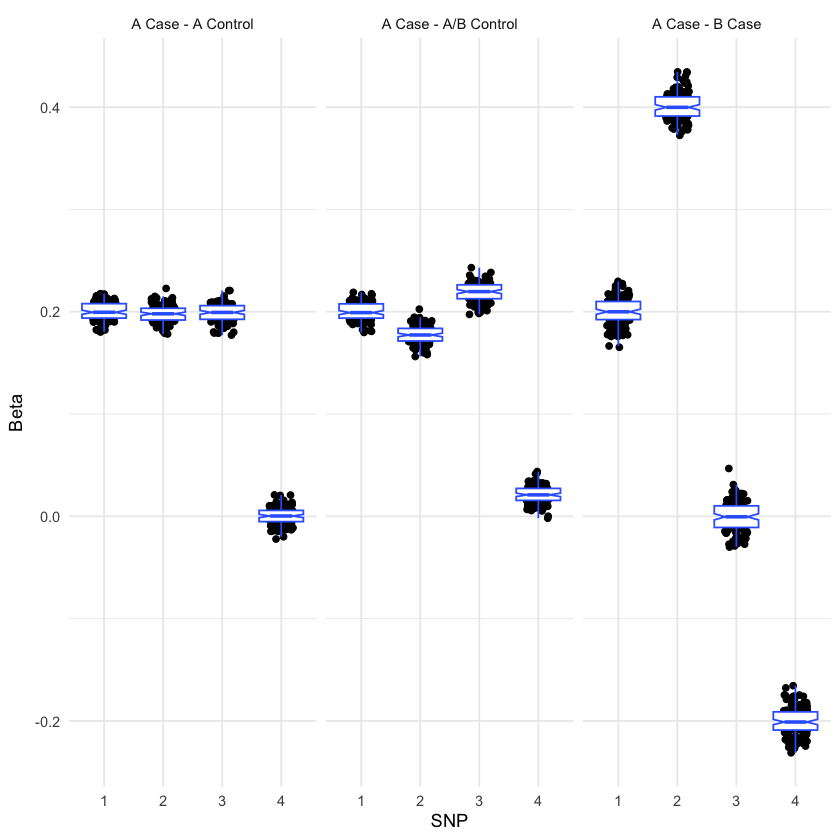

In [20]:
ggplot(dag_simulations, aes(x = str_remove(term, pattern="SNP"), y = Estimate)) +
  geom_jitter(width = 0.2) +
  geom_boxplot(notch = TRUE, colour = "#3366FF", outlier.shape = NA) +
  facet_grid(cols = vars(model)) +
  theme_minimal() +
  scale_x_discrete("SNP") +
  scale_y_continuous("Beta")
ggsave("casecontrol-sim.png", width=5, height=4, dpi=300, bg = "white")